In [1]:
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')


Just checking the data has been read properly by python and exploring the way the data is built

In [3]:
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


We want to check the how balanced the dataset is - we will check how much percent of the dataset is spam and how much is harmless.

In [4]:
print(sum(data['label_num'])/len(data))

0.2898859021465867


*We* can see that the percentage of the spam is 28% - which gives us a fairly balanced dataset

The first thing we are going to do is the text pre-processing
This includes: 
1. Tokenization - turning each word into a single token
2. Lowercase all words - lower all capital words
3. Remove punctuation - exactly as it sounds
4. Remove stopwords - remove stopwords such as a, it, the - normally doesn't help with text classification

In [5]:
data['tokenized'] = data['text'].apply(word_tokenize)
data.head()

,Unnamed: 0,label,text,label_num,tokenized
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea..."


In [6]:
data['lower'] = data['tokenized'].apply(lambda x: [word.lower() for word in x])
data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea..."


In [7]:
import string

punc = string.punctuation
data['no_punc'] = data['lower'].apply(lambda x: [word for word in x if word not in punc])
data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower,no_punc
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ...","[subject, enron, methanol, meter, 988291, this..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, hpl, nom, for, january, 9, 2001, see..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, neon, retreat, ho, ho, ho, we, re, a..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,...","[subject, photoshop, windows, office, cheap, m..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea...","[subject, re, indian, springs, this, deal, is,..."


In [8]:
stop_words = set(stopwords.words('english'))
data['stopwords_removed'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower,no_punc,stopwords_removed
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ...","[subject, enron, methanol, meter, 988291, this...","[subject, enron, methanol, meter, 988291, foll..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, hpl, nom, for, january, 9, 2001, see...","[subject, hpl, nom, january, 9, 2001, see, att..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, neon, retreat, ho, ho, ho, we, re, a...","[subject, neon, retreat, ho, ho, ho, around, w..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea...","[subject, re, indian, springs, this, deal, is,...","[subject, indian, springs, deal, book, teco, p..."


We are now going to do some EDA

*First* stage is to create a list of all the words and then we can turn this into a frequency matrix

In [9]:
words = data['stopwords_removed']
allwords = []
for wordlist in words:
    allwords += wordlist

In [10]:
from wordcloud import WordCloud, ImageColorGenerator

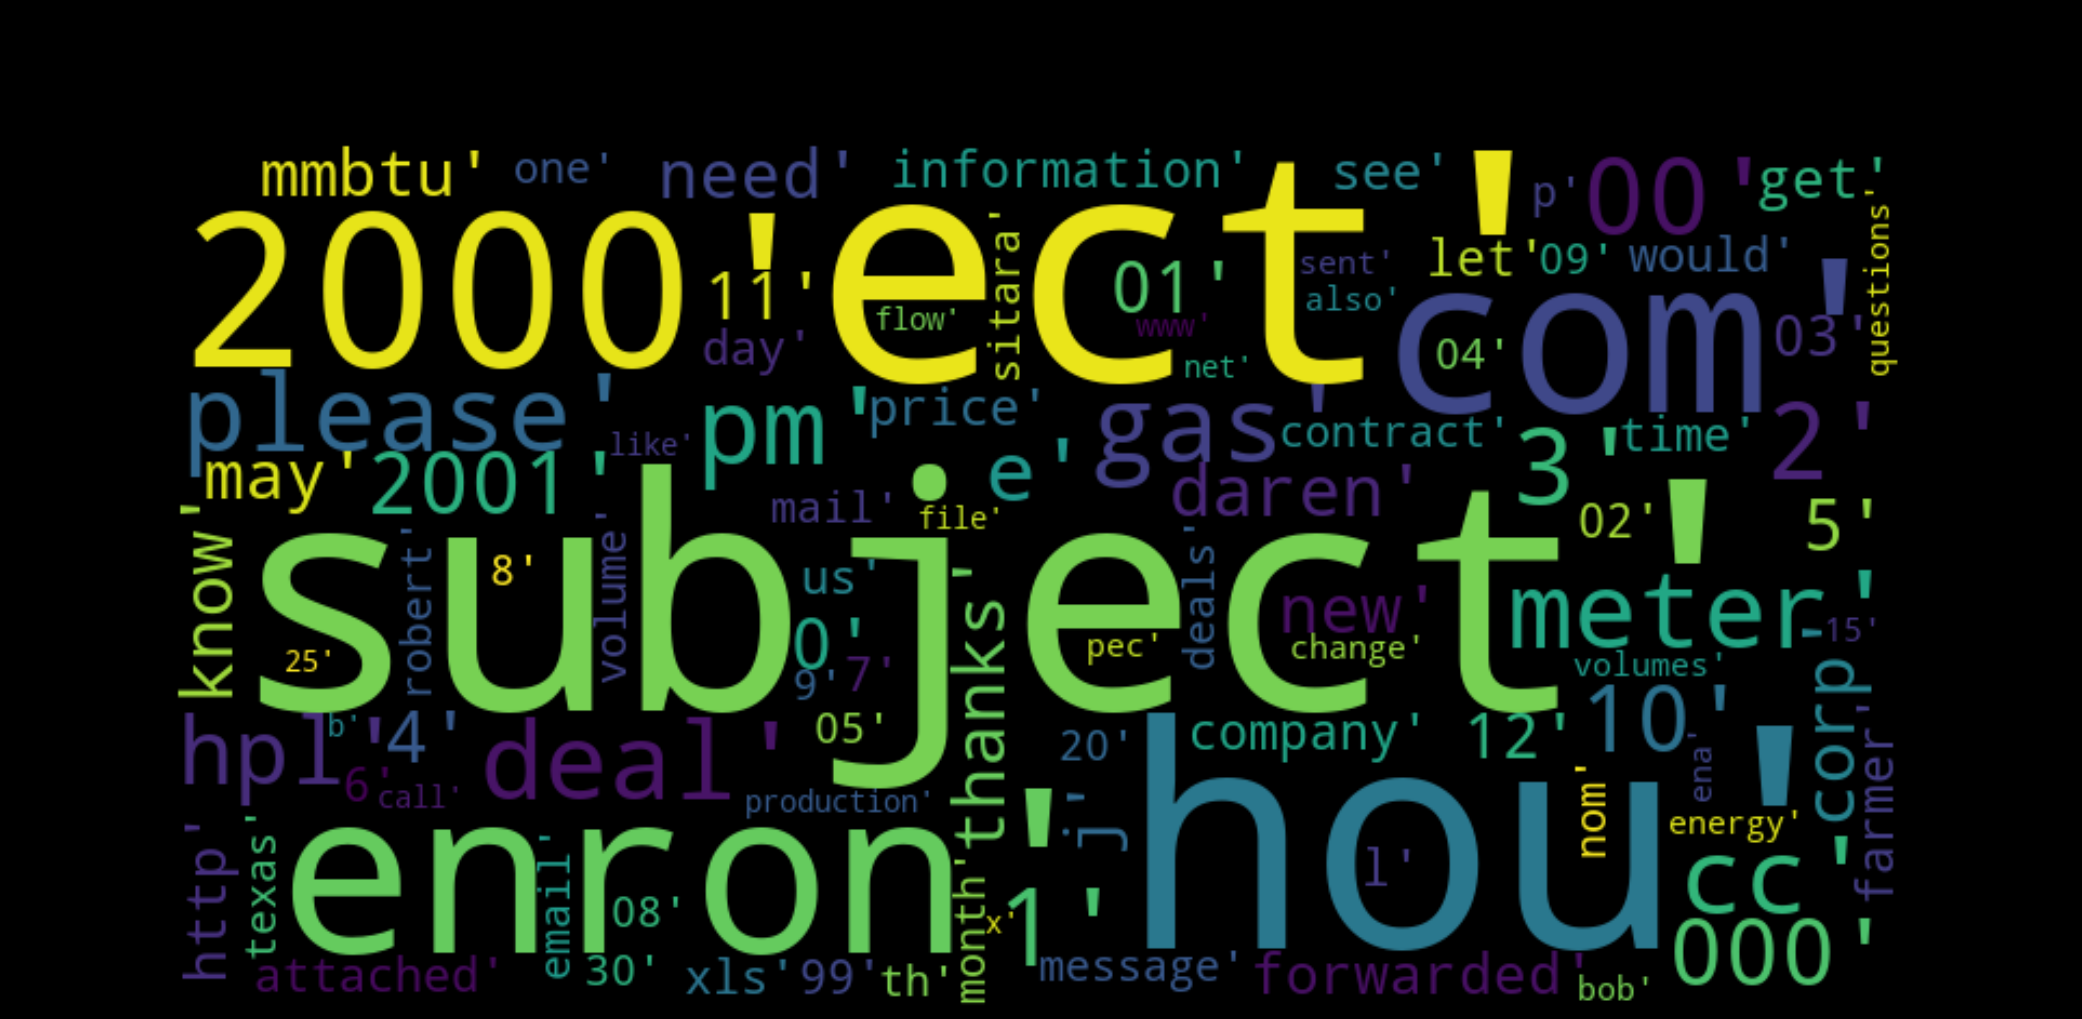

In [11]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

We can see from this word cloud that a lot of the top 100 words are general email related words such as: com, http, cc, subject, mail,forwarded, numbers (probably from dates), etc. 

What we will do now is first remove all number from the vocabulary and after that we will create another word cloud 

In [12]:
data['numbers_removed'] = data['stopwords_removed'].apply(lambda x: [word for word in x if word.isnumeric() == False])
data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower,no_punc,stopwords_removed,numbers_removed
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ...","[subject, enron, methanol, meter, 988291, this...","[subject, enron, methanol, meter, 988291, foll...","[subject, enron, methanol, meter, follow, note..."
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, hpl, nom, for, january, 9, 2001, see...","[subject, hpl, nom, january, 9, 2001, see, att...","[subject, hpl, nom, january, see, attached, fi..."
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, neon, retreat, ho, ho, ho, we, re, a...","[subject, neon, retreat, ho, ho, ho, around, w...","[subject, neon, retreat, ho, ho, ho, around, w..."
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m..."
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea...","[subject, re, indian, springs, this, deal, is,...","[subject, indian, springs, deal, book, teco, p...","[subject, indian, springs, deal, book, teco, p..."


In [13]:
words = data['numbers_removed']
allwords = []
for wordlist in words:
    allwords += wordlist

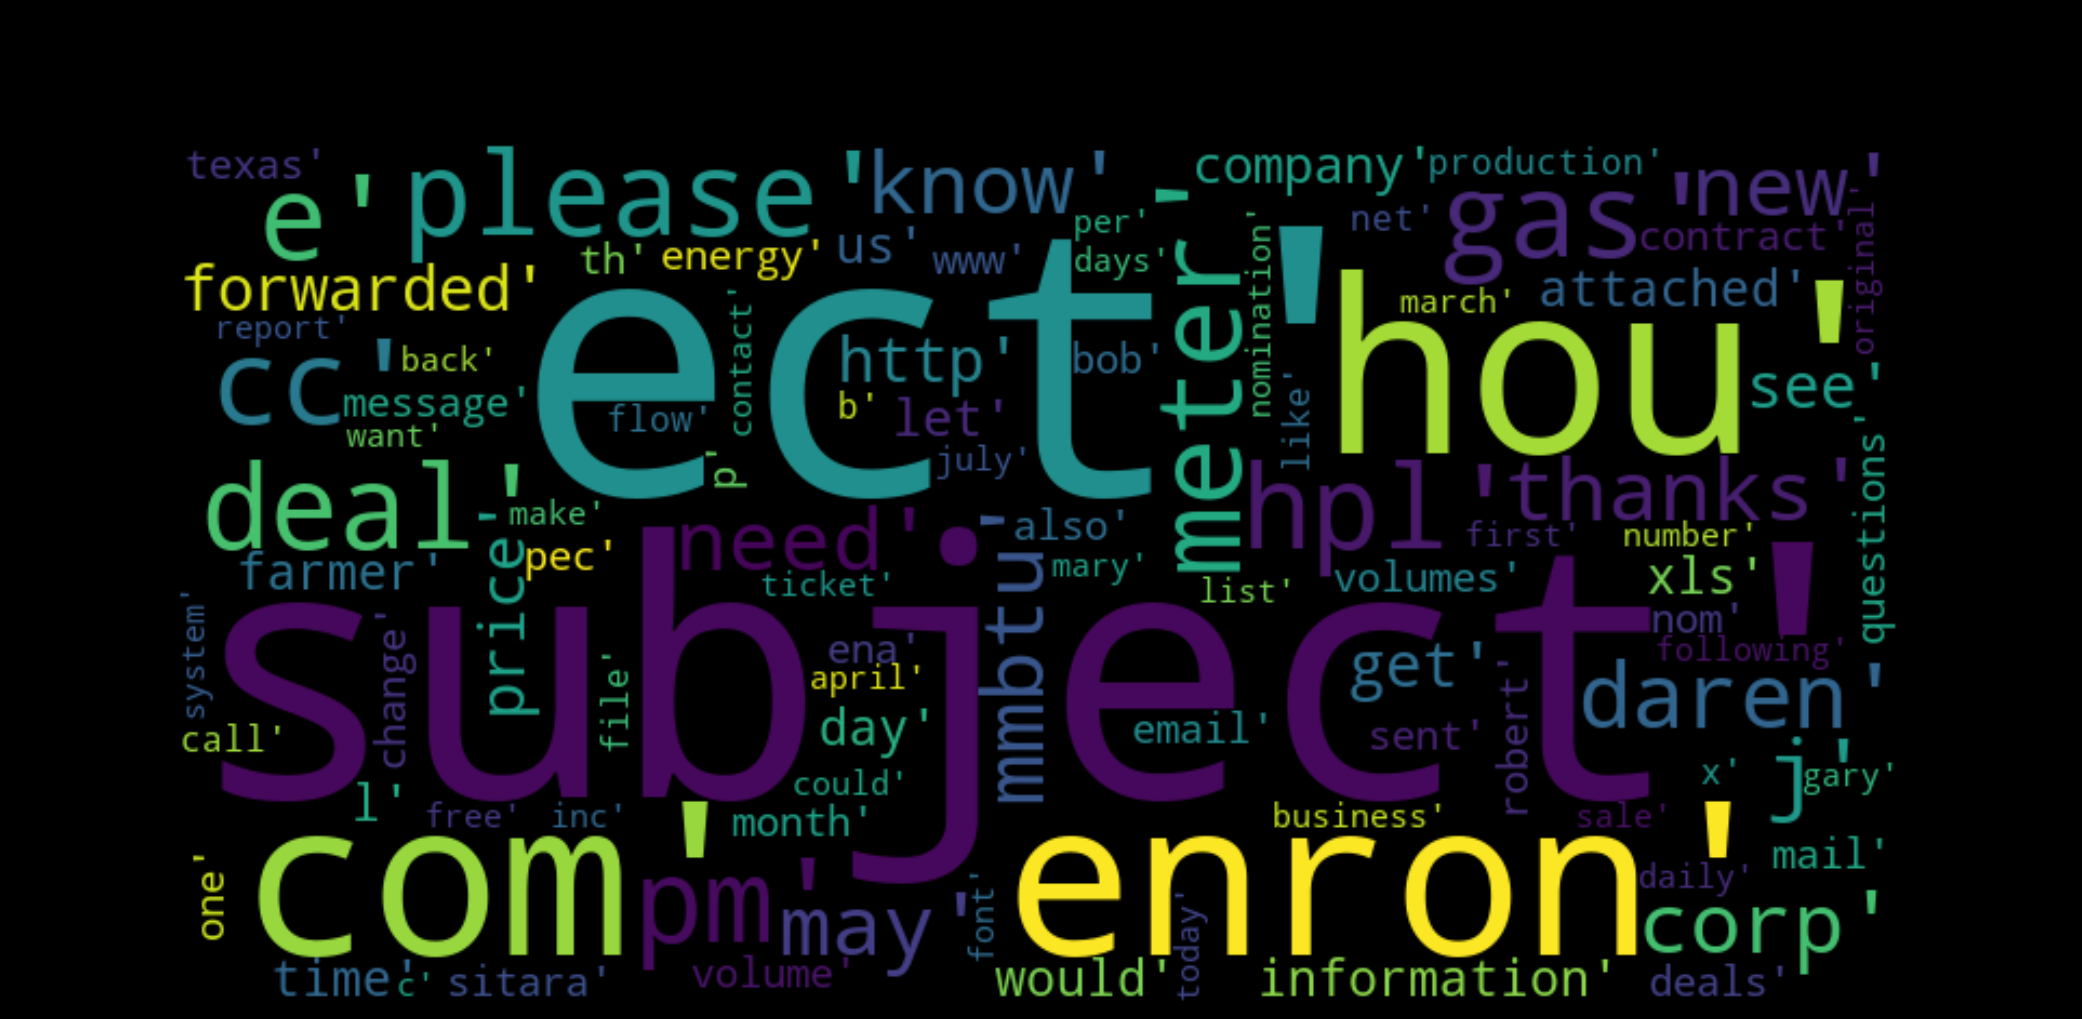

In [14]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [15]:
spamwords = []
hamwords = []
# Iterate all rows using DataFrame.iterrows()
for index, row in data.iterrows():
  if row["label"] == 'ham':
    hamwords += row["numbers_removed"]
  else:
    spamwords += row["numbers_removed"]

Now we are going to present two different word clouds - one for the spam and one for the ham

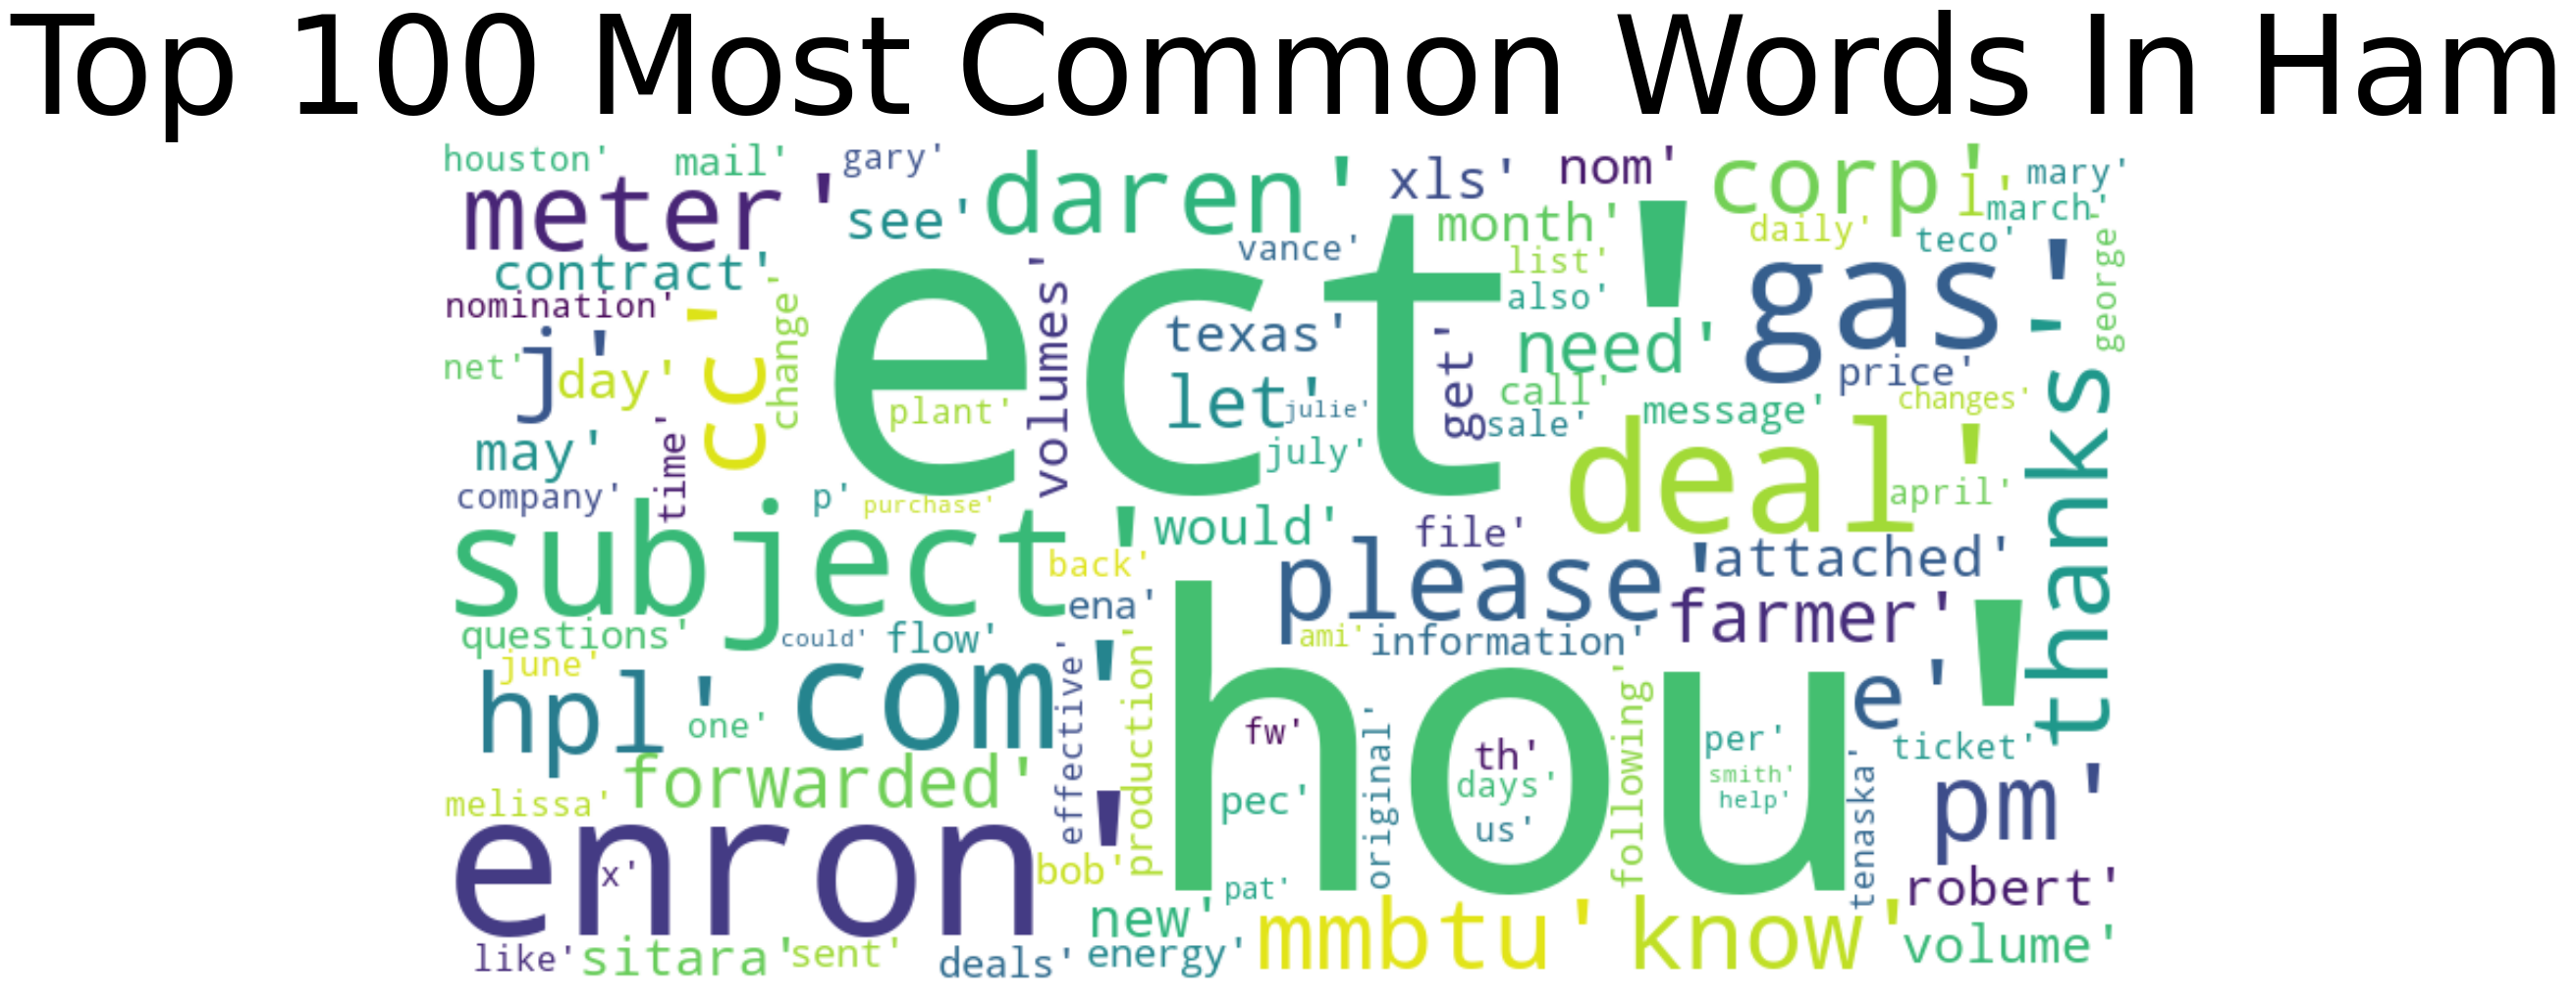

In [16]:
mostcommon = FreqDist(hamwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words In Ham', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

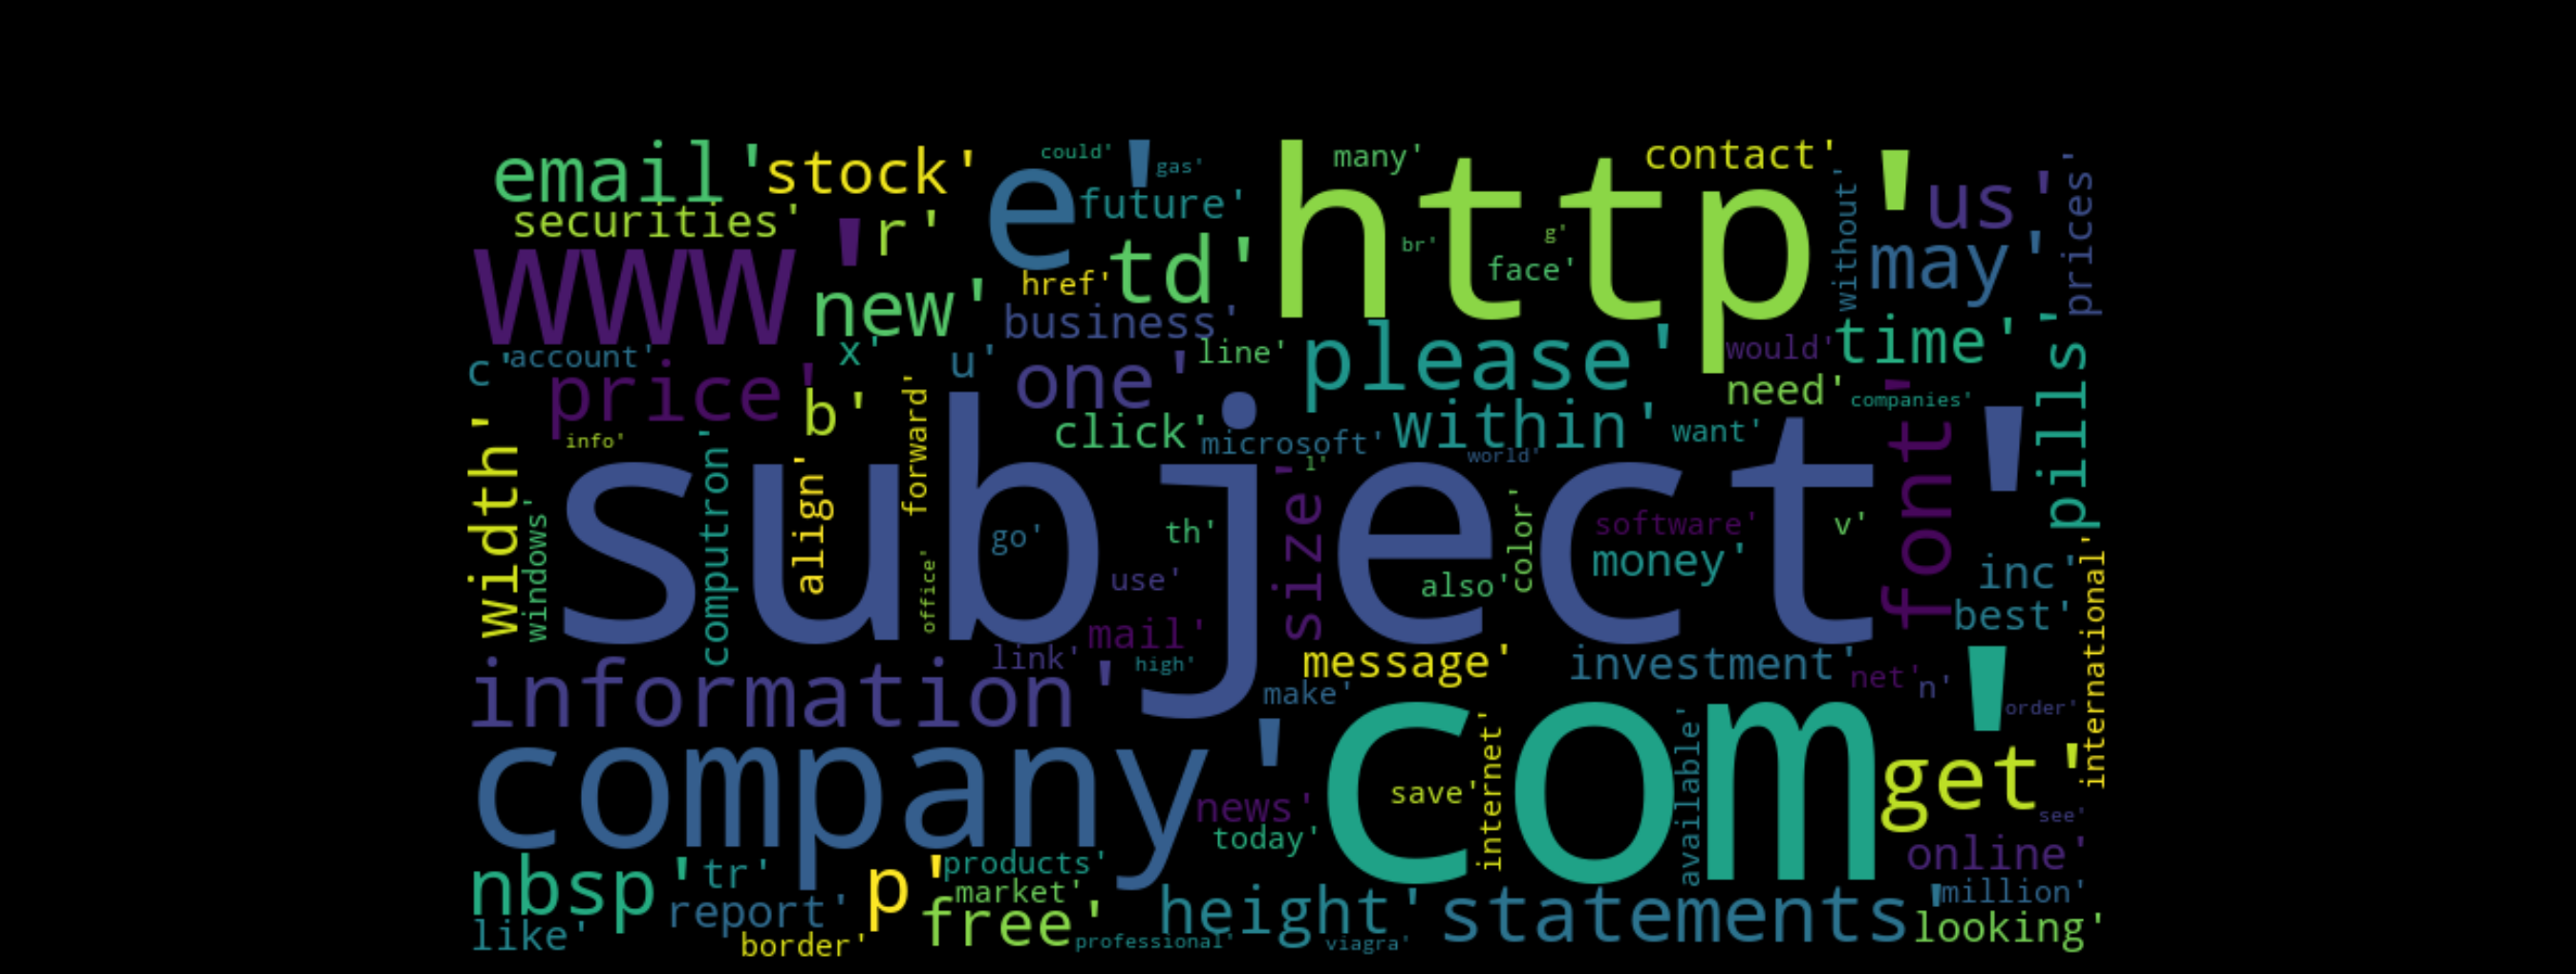

In [17]:
mostcommon = FreqDist(spamwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words In Spam', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [18]:
spamwords_value = []
hamwords_value = []
for word in FreqDist(spamwords).most_common(100):
  spamwords_value.append(word[0])
for word in FreqDist(hamwords).most_common(100):
  hamwords_value.append(word[0])

len(list(set(spamwords_value) - set(hamwords_value)))

72

We can see that there are 72 words from the top 100 words that aren't in the top 100 for the hamwords - we should take these 72 words as part of the features

In [19]:
spam_feature_words = list(set(spamwords_value) - set(hamwords_value))
data['spam_feature_words'] = data['numbers_removed'].apply(lambda x: [word for word in x if word in spam_feature_words])
data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower,no_punc,stopwords_removed,numbers_removed,spam_feature_words
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ...","[subject, enron, methanol, meter, 988291, this...","[subject, enron, methanol, meter, 988291, foll...","[subject, enron, methanol, meter, follow, note...",[]
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, hpl, nom, for, january, 9, 2001, see...","[subject, hpl, nom, january, 9, 2001, see, att...","[subject, hpl, nom, january, see, attached, fi...",[]
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, neon, retreat, ho, ho, ho, we, re, a...","[subject, neon, retreat, ho, ho, ho, around, w...","[subject, neon, retreat, ho, ho, ho, around, w...","[go, without, go, www, email, available, go]"
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m...","[windows, office]"
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea...","[subject, re, indian, springs, this, deal, is,...","[subject, indian, springs, deal, book, teco, p...","[subject, indian, springs, deal, book, teco, p...",[]


Now we are going to make the list of words tokenized back into a full sentence in order for the sklearn count vectorizer to work on the features

In [20]:
data['processed'] = [' '.join(map(str, l)) for l in data['numbers_removed']]
data['spam_features'] = [' '.join(map(str, l)) for l in data['spam_feature_words']]

data.head()

,Unnamed: 0,label,text,label_num,tokenized,lower,no_punc,stopwords_removed,numbers_removed,spam_feature_words,processed,spam_features
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,"[Subject, :, enron, methanol, ;, meter, #, :, ...","[subject, :, enron, methanol, ;, meter, #, :, ...","[subject, enron, methanol, meter, 988291, this...","[subject, enron, methanol, meter, 988291, foll...","[subject, enron, methanol, meter, follow, note...",[],subject enron methanol meter follow note gave ...,
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[Subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, :, hpl, nom, for, january, 9, ,, 200...","[subject, hpl, nom, for, january, 9, 2001, see...","[subject, hpl, nom, january, 9, 2001, see, att...","[subject, hpl, nom, january, see, attached, fi...",[],subject hpl nom january see attached file hpln...,
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[Subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, :, neon, retreat, ho, ho, ho, ,, we,...","[subject, neon, retreat, ho, ho, ho, we, re, a...","[subject, neon, retreat, ho, ho, ho, around, w...","[subject, neon, retreat, ho, ho, ho, around, w...","[go, without, go, www, email, available, go]",subject neon retreat ho ho ho around wonderful...,go without go www email available go
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,"[Subject, :, photoshop, ,, windows, ,, office,...","[subject, :, photoshop, ,, windows, ,, office,...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m...","[subject, photoshop, windows, office, cheap, m...","[windows, office]",subject photoshop windows office cheap main tr...,windows office
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,"[Subject, :, re, :, indian, springs, this, dea...","[subject, :, re, :, indian, springs, this, dea...","[subject, re, indian, springs, this, deal, is,...","[subject, indian, springs, deal, book, teco, p...","[subject, indian, springs, deal, book, teco, p...",[],subject indian springs deal book teco pvr reve...,


# Model Creation

After the data exploration we will now create a matrix with the features we choose and see what the results are 

The first stage we are going to tokenize the emails and use all the words in the bag of words we are creating - we will see if using all the words is a good solution or if using certain words is better

In [21]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(data['processed'])

**The** first stage after pre-processing the data is splitting the data randomly into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label_num'], test_size=0.25, random_state=42)

The first classification algorithm we chose was the Logisitic Regression Model

In [23]:
clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)

After using the model to predict the values of the test set we are going to check the different scores for the model.

In [24]:
all_lr_recall = recall_score(y_pred, y_test)
all_lr_precision = precision_score(y_pred, y_test)
all_lr_accuracy = accuracy_score(y_pred, y_test)
all_lr_f1 = f1_score(y_pred, y_test)

In [25]:
all_lr = ['Logistic Regression on all tokens' ,all_lr_recall, all_lr_precision, all_lr_accuracy, all_lr_f1]
print(all_lr_recall, all_lr_precision, all_lr_accuracy, all_lr_f1)

0.944 0.9752066115702479 0.9767981438515081 0.959349593495935


We can see that the accuracy is high but the recall and precision are slightly lower. We could change the weight of each of the classes depending on the business case and the decision of the organization. 
If we are talking about children's emails - it would make sense to make the model more sensitive to spam - and therefore penalize false negatives - since it is important that they don't see anything inappopriate. If it is important that clients see all their emails and they aren't so sensitive to spam we could penalize false positives.

*Now* we will do the same using the Linear SVC algorithm.

In [26]:
clf_svc = LinearSVC(random_state=0).fit(X_train, y_train)

y_pred = clf_svc.predict(X_test)

C:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
all_svc_recall = recall_score(y_pred, y_test)
all_svc_precision = precision_score(y_pred, y_test)
all_svc_accuracy = accuracy_score(y_pred, y_test)
all_svc_f1 = f1_score(y_pred, y_test)

In [28]:
all_svc = ['SVC on all tokens', all_svc_recall, all_svc_precision, all_svc_accuracy, all_svc_f1]
print(all_svc_recall, all_svc_precision, all_svc_accuracy, all_svc_f1)

0.94579945799458 0.9614325068870524 0.9737045630317092 0.9535519125683061


We can see that the model using the SVC algorithm is almost exactly the same as the Logistic Regression scores.




The next experiment will be taking the top 100 words and seeing if that provides better or worse results. The risk of using so many features is that this could make the model prone to variance and cause it to overfit. Using the top 100 words might help with overfitting and making sure that the model doesn't just memorize the train set.

In [29]:
count_vect = CountVectorizer(max_features=100)
X = count_vect.fit_transform(data['processed'])

We will do exactly the same as before 

1.   List item
2.   List item

just using a much less sparse bag of words matrix.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label_num'], test_size=0.25, random_state=42)

In [31]:
clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)

In [32]:
hun_lr_recall = recall_score(y_pred, y_test)
hun_lr_precision = precision_score(y_pred, y_test)
hun_lr_accuracy = accuracy_score(y_pred, y_test)
hun_lr_f1 = f1_score(y_pred, y_test)

In [33]:
hun_lr = ['Logistic Regression on Top 100 words', hun_lr_recall, hun_lr_precision, hun_lr_accuracy, hun_lr_f1]
print(hun_lr_recall, hun_lr_precision, hun_lr_accuracy, hun_lr_f1)

0.8564356435643564 0.953168044077135 0.9419953596287703 0.9022164276401564


All 3 of the scores have been highly affected. It proves not to be a good idea to take the top 100 words. Using the top 100 words probably makes the model underfit and not learn enough about the data in order to predict the spam. We can see that the recall has been affected very badly. 

In [34]:
clf_svc = LinearSVC(random_state=0).fit(X_train, y_train)

y_pred = clf_svc.predict(X_test)

C:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
hun_svc_recall = recall_score(y_pred, y_test)
hun_svc_precision = precision_score(y_pred, y_test)
hun_svc_accuracy = accuracy_score(y_pred, y_test)
hun_svc_f1 = f1_score(y_pred, y_test)

In [36]:
hun_svc = ['SVC on Top 100 words', hun_svc_recall, hun_svc_precision, hun_svc_accuracy, hun_svc_f1]
print(hun_svc_recall, hun_svc_precision, hun_svc_accuracy, hun_svc_f1)

0.8668341708542714 0.9504132231404959 0.9450889404485692 0.9067017082785809


Here again, we see that choosing the top 100 words was not a good decision.

Now we are going to do the same for the spam features we created and see what results that will produce 

In [37]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(data['spam_features'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label_num'], test_size=0.25, random_state=42)

In [39]:
clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)

In [40]:
spam_recall = recall_score(y_pred, y_test)
spam_precision = precision_score(y_pred, y_test)
spam_accuracy = accuracy_score(y_pred, y_test)
spam_f1 = f1_score(y_pred, y_test)

In [41]:
spam_lr = ['Logistic Regression on hand-picked spam words', spam_recall, spam_precision, spam_accuracy, spam_f1]
print(spam_recall, spam_precision, spam_accuracy, spam_f1)

0.82 0.45179063360881544 0.8182521268368136 0.5825932504440497


Here we can see that the recall and accuracy are not high but are ok, but the precision is absolutely terrible, the reason for this is probably because the 72 words aren't in all emails - which creates very a sparse representation of the original data and we lose a lot of data

# Results

We are now going to present the results in a table 

In [42]:
results = [all_lr, all_svc, hun_lr, hun_svc, spam_lr]
col_names = ['Model', 'Recall', 'Precision', 'Accuracy', 'F1 Score']

print(tabulate(results, headers=col_names))

Model                                            Recall    Precision    Accuracy    F1 Score
---------------------------------------------  --------  -----------  ----------  ----------
Logistic Regression on all tokens              0.944        0.975207    0.976798    0.95935
SVC on all tokens                              0.945799     0.961433    0.973705    0.953552
Logistic Regression on Top 100 words           0.856436     0.953168    0.941995    0.902216
SVC on Top 100 words                           0.866834     0.950413    0.945089    0.906702
Logistic Regression on hand-picked spam words  0.82         0.451791    0.818252    0.582593


As we said throughout the last chapter, we think that the reason for these results is because choosing a certain amount of features causes the us to lose a lot of data and this causes underfitting - where we aren't learning enough about each of the emails. For that reason we think that the model the performed the best was the model that chose all the words from the processed email, and the other models that only chose a certain amount of features didn't perform as well. 

Further experiments that can be done on this dataset is checking what happens when different parts of the pre-processing are added or not. It could be that spam emails contain large amounts of punctuation etc. and that removing punctuation caused us to lose critical data. This could be true for different stages of the pre-processing.